전체 적인 아이디어는
train.csv 에서 각각의 Y(Y00 ~ Y17)에 대하여 30일을 이용해 학습을 한 후에 3일 뒤의 Y와 test의 80일을 각각 예측한다.  
그 후에 3일 뒤의 예측한 Y(00 ~ 17)와 X(00 ~ 39)를 이용해 Y18을 예측하는 모델을 학습 시키고 이 모델을 이용하여 test.csv의 80일의 Y18을 예측한다.

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import gc

import xgboost as xgb
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold, GroupKFold, TimeSeriesSplit

pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_column', 500)

import warnings
warnings.filterwarnings(action='ignore')

# DataFrame size reduce 
from Reducing_DF_memory_size import reduce_mem_usage

In [12]:
from sklearn.metrics import make_scorer

def mse_AIFrenz(y_true, y_pred):
    '''
    y_true: 실제 값
    y_pred: 예측 값
    '''
    diff = abs(y_true - y_pred)
    
    less_then_one = np.where(diff < 1, 0, diff)
    
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    score = np.average(np.average(less_then_one ** 2, axis = 0))
    
    return score

custom_scorer = make_scorer(mse_AIFrenz, 
                            greater_is_better=False)

#표준화 함수 생성
def normalization(df):
    mean = df.mean()
    std = df.std()
    norm = (df - mean) / (std + 1e-07)
    return norm, mean, std

# 풍향 encoding
def wind_direction(wind):
  if (wind > 340) or (wind <= 20):
    return 0 # north
  elif (20< wind) & (wind <= 70):
    return 1 # north west
  elif (70 < wind) & (wind <= 110):
    return 2 # west
  elif (110< wind) & (wind <= 160):
    return 3 # south west
  elif (160 < wind) & (wind <= 200):
    return 4 # south
  elif (200 < wind) & (wind <= 250):
    return 5 # west east
  elif (250 < wind) & (wind <= 290):
    return 6 # east
  elif (290 < wind) & (wind <= 340):
    return 7 # north east


In [13]:
# data load
train_df = pd.read_csv('AIFrenz_Season1_dataset/train.csv')
test_df = pd.read_csv('AIFrenz_Season1_dataset/test.csv')

간단한 전처리

In [14]:
# wind_direction
for i in ['X13', 'X15', 'X17', 'X25', 'X35']:
    train_df[i] =  train_df[i].apply(lambda x: wind_direction(x)).values.copy()
    test_df[i] =  test_df[i].apply(lambda x: wind_direction(x)).values.copy()

Y_cols = [col for col in train_df if col.startswith('Y')]

# 다 0인것 삭제
train_df.drop(['X14', 'X16', 'X19'], axis = 1, inplace = True)
test_df.drop(['X14', 'X16', 'X19'], axis = 1, inplace = True)

#Stadatd scale
train_df.loc[:,'X00':'X39'], _, _  = normalization(train_df.loc[:,'X00':'X39'])
test_df.loc[:,'X00':'X39'], _, _  = normalization(test_df.loc[:,'X00':'X39'])

# hour 변수 생성
minute = (train_df.index%144).astype(int)
train_df['hour'] = np.cos((minute/6 - 15)/24 * np.pi * 2)

minute_test = (test_df.index%144).astype(int)
test_df['hour'] = np.cos((minute_test/6 - 15)/24 * np.pi * 2)

In [15]:
# target column & data
Y_cols = [col for col in train_df if col.startswith('Y')]
Y_data = train_df[Y_cols].copy()

# data_split
val_df = train_df.loc[~train_df['Y18'].isna()]
train_df = train_df.loc[train_df['Y18'].isna()]

In [16]:
# SETTINGS - CHANGE THESE TO GET SOMETHING MEANINGFUL
ITERATIONS = 10 # 1000

bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBRegressor(
        n_jobs = -1,
        objective = 'reg:squarederror',
        eval_metric = 'rmse',
        silent=1,
        tree_method='auto' # 
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (2, 50),#50
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 1000),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
    scoring = custom_scorer,
    cv = TimeSeriesSplit(
        n_splits=3,
    ),
    n_jobs = -1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    # CV 점수 중간에 출력 
#     print('Model #{}\nBest MSE: {}\nBest params: {}\n'.format(
#         len(all_models),
#         np.round(bayes_cv_tuner.best_score_, 4),
#         bayes_cv_tuner.best_params_
#     ))
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
#    all_models.to_csv(clf_name+"_cv_results.csv")

In [17]:
X = train_df.drop(Y_cols + ['id'], axis = 1) # X column 만 이용
X, __ =  reduce_mem_usage(X) # data type 통일 

val_best_score_list = [] # 30일 cv score
test_score = [] # 다른 Y로 Y18을 예측했을땐=의 score
best_parm_list ={} # 각각의 Y에 따른 모델의 best parameter
pred_df = pd.Series([]) # 3일 예측치를 담을 DataFrame
pred_test_df = pd.Series([]) # 80일치 예측치를 담을 DataFrame

for i in range(len(Y_cols)-1):
    print(Y_cols[i] + '시작')
          
    y = train_df[Y_cols[i]]
    
    result = bayes_cv_tuner.fit(X, y, callback=status_print) # tune
    val_best_score_list.append(result.best_score_) # validation_score
    best_parm_list[Y_cols[i]] = result.best_estimator_.get_params() # best_param
    
    pred = result.predict(val_df.drop(Y_cols+['id'], axis = 1)) # pred
    pred_df = pd.concat([pred_df, pd.Series(pred)], axis = 1) # pred_append
    test_score.append(mse_AIFrenz(val_df['Y18'], pred)) # test append
    
    pred_test_df = pd.concat([pred_test_df, pd.Series(result.predict(test_df.drop(['id'], axis = 1)))], axis = 1)
    
    print(Y_cols[i] + '끝')

Memory usage of properties dataframe is : 1.285400390625  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.646820068359375  MB
This is  50.32051282051282 % of the initial size
Y00시작
Y00끝
Y01시작
Y01끝
Y02시작
Y02끝
Y03시작
Y03끝
Y04시작
Y04끝
Y05시작
Y05끝
Y06시작
Y06끝
Y07시작
Y07끝
Y08시작
Y08끝
Y09시작
Y09끝
Y10시작
Y10끝
Y11시작
Y11끝
Y12시작
Y12끝
Y13시작
Y13끝
Y14시작
Y14끝
Y15시작
Y15끝
Y16시작
Y16끝
Y17시작
Y17끝


파란색 선은 튜닝하면서 기록한 CV score  
주황색선은 각각의 다른 Y로 학습 후 Y18을 3일간 예측했을때 얻은 test score

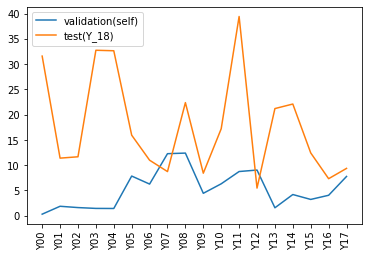

In [18]:
# val_best_score_list = []
plt.plot(Y_cols[:-1],list(map(abs,val_best_score_list)), label = 'validation(self)')
plt.plot( test_score, label = 'test(Y_18)')
plt.legend(loc='upper left')
plt.xticks(rotation=90)
plt.show()

- pred_df : train_df의 30일 기록된 Y들로 학습 후 각각의 Y의 나머지 3일을 예측한 data
- pred_test_df : train_df의 30일록 학습한 후 각각 Y 80일을 예측했다.
- val_df : train_df 에서 3일치 data를 따로 빼둔것  
pred_df와 val_df 합쳐서 3일 data로 Y18 예측하도록 한 후 pred_test_df & test_df 합쳐서 80일 Y18 예측  
**다른Y를 이용해서 Y18예측 하겠다**

In [21]:
# 예측한 값들 있는 Data Frame의 컬럼이름_

In [34]:
val_df.reset_index(drop=True, inplace = True)
val_df[Y_cols[:-1]] = pred_df[Y_cols[:-1]].copy()

Index(['X00', 'X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08', 'Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'hour'], dtype='object')

In [40]:
# 똗같은 함수 이용해서 parameter tune 
result_XGB = bayes_cv_tuner.fit(val_df.drop(['Y18','id'], axis = 1), 
                                val_df['Y18'], callback=status_print)
time_folds = TimeSeriesSplit(n_splits = 3)

a = []
# cv.score 확인
for n_fold, (tr_idx, val_idx) in enumerate(time_folds.split(val_df.drop(['Y18','id'], axis = 1), val_df['Y18'])):
    trn_x, trn_y = val_df.drop(['Y18','id'], axis = 1).iloc[tr_idx], val_df['Y18'].iloc[tr_idx]
    val_x, val_y = val_df.drop(['Y18','id'], axis = 1).iloc[val_idx], val_df['Y18'].iloc[val_idx]
    
    # create linear regression object 
    model = xgb.XGBRegressor(**result_XGB.best_estimator_.get_params())
    # train the model using the training sets 
    model.fit(trn_x, trn_y)
    fold_pred = model.predict(val_x)
    
    print('Fold %2d MSE : %.6f' %
              (n_fold + 1, mse_AIFrenz(val_y, fold_pred)))
          
    a.append(mse_AIFrenz(val_y, fold_pred))

Fold  1 MSE : 9.287594
Fold  2 MSE : 3.264213
Fold  3 MSE : 4.533494


## submission

In [65]:
feature_list = list(val_df.drop(['Y18','id'], axis = 1).columns)


In [68]:
feature_list = list(val_df.drop(['Y18','id'], axis = 1).columns)
pd.DataFrame({'id' : test_df['id'], 'Y18' : result_XGB.predict(test_df.drop('id',axis = 1)[feature_list])}).to_csv('submission.csv', index = False)